In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch.nn import functional as F
%matplotlib inline

In [2]:
names = open("../datasets/llm/names.txt",mode="r",encoding="utf8").read().splitlines()
names[:5]

['emma', 'olivia', 'ava', 'isabella', 'sophia']

In [3]:
vocab = "".join(sorted(set(x for word in names+["."] for x in word))) # building vocab

In [4]:
stoi = {k:v for v,k in enumerate(vocab)}
itos = {v:k for v,k in enumerate(vocab)}

In [5]:
torch.set_default_device("mps")
def build_dataset(data, n_context):
    xs = []
    ys = []
    
    for x in data:
        context = [0]* n_context
        for ch in x + ".":
            # print(f"{context} {stoi[ch]}")
            ix = stoi[ch]
            xs.append(context)
            ys.append(ix)
            context = context[1:]+[ix]
    xs = torch.tensor(xs)
    ys = torch.tensor(ys)
    print(xs.shape,ys.shape)
    return xs,ys

np.random.shuffle(names)

data_size =  len(names)
n_context = 3
train_data = names[:int(data_size * .8)]
dev_data = names[int(data_size * .8):int(data_size * .9)]
test_data = names[int(data_size * .9):]

Xtr,Ytr = build_dataset(train_data,n_context) 
Xdev,Ydev = build_dataset(dev_data,n_context)
Xtest,Ytest = build_dataset(test_data,n_context)

torch.Size([182415, 3]) torch.Size([182415])
torch.Size([22792, 3]) torch.Size([22792])
torch.Size([22939, 3]) torch.Size([22939])


In [6]:
Xtr

tensor([[ 0,  0,  0],
        [ 0,  0, 11],
        [ 0, 11, 18],
        ...,
        [ 1,  5, 19],
        [ 5, 19, 25],
        [19, 25, 14]], device='mps:0')

In [78]:
e_dim = 10
h_dim = 200
g = torch.Generator(device = "mps:0").manual_seed(2147483647)
C = torch.randn(len(vocab), e_dim, generator=g) # character embeddings with dimension of 2
W1 = torch.randn(n_context*e_dim, h_dim, generator=g) * 0.01
b1 = torch.randn(h_dim, generator=g) * 0.01
W2 = torch.randn(h_dim,len(vocab), generator=g) * 0.01
b2 = torch.randn(len(vocab), generator=g) * 0.01

parameters = [C,W1,b1,W2,b2]

In [79]:
lrs = torch.linspace(-3,1,20)
loglrs = 10**lrs

In [80]:
lrsloss = []

In [52]:
sum( p.nelement() for p in parameters)

11897

In [53]:
for p in parameters:
    p.requires_grad = True

In [54]:
batch_size = 32
lrsloss = []
for i in range(200000):
    #forward pass
    ix = torch.randint(0,high = Xtr.shape[0],size=(batch_size,))
    emb = C[Xtr[ix]]
    out = emb.view(-1,n_context*e_dim) @ W1 + b1
    out =  torch.tanh(out)
    out = out @ W2 + b2
    loss = F.cross_entropy(out,Ytr[ix])
    if i % 10000 == 0:
        print(F"loss at {i}/200000 {loss.item():.4f}")
    for p in parameters:
        p.grad = None 
    #backpass
    loss.backward()
    
    #update
    lr = 0.1 if i <100000 else 0.01
    for p in parameters:
        p.data += -lr*p.grad
print(F" Final loss: {loss.item():.4f}")

loss at 0/200000 3.2974
loss at 10000/200000 2.8417
loss at 20000/200000 2.0994
loss at 30000/200000 2.1696
loss at 40000/200000 2.2701
loss at 50000/200000 1.9801
loss at 60000/200000 2.1495
loss at 70000/200000 2.1760
loss at 80000/200000 2.3460
loss at 90000/200000 2.0584
loss at 100000/200000 1.9946
loss at 110000/200000 2.1287
loss at 120000/200000 2.1147
loss at 130000/200000 1.9853
loss at 140000/200000 2.4270
loss at 150000/200000 2.1913
loss at 160000/200000 2.6433
loss at 170000/200000 1.9272
loss at 180000/200000 2.0089
loss at 190000/200000 2.3425
 Final loss: 2.0574


In [55]:
#dev validation
with torch.no_grad():
    # ix = torch.randint(0,high = Xtr.shape[0],size=(batch_size,))
    emb = C[Xdev]
    out = emb.view(-1,n_context*e_dim) @ W1 + b1
    out =  torch.tanh(out)
    out = out @ W2 + b2
    loss = F.cross_entropy(out,Ydev)
    print(loss)

tensor(2.1358, device='mps:0')


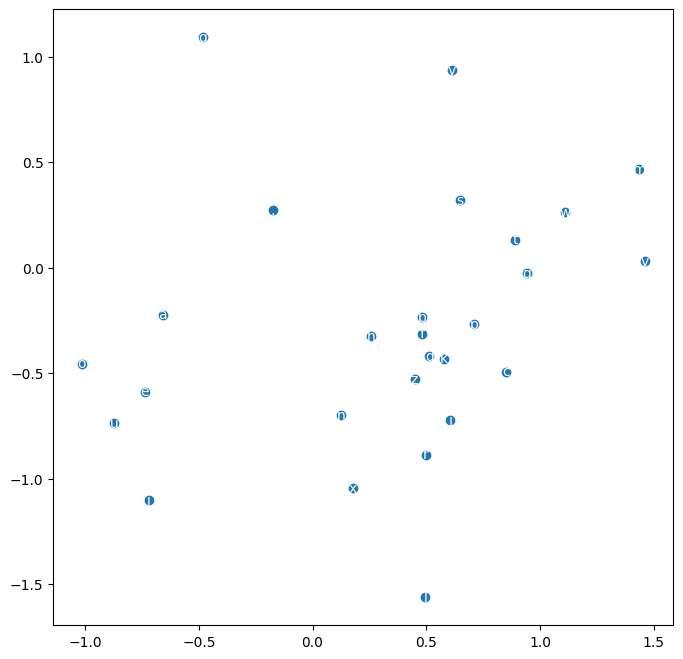

In [230]:
plt.figure(figsize=(8,8))
i=0
C1 = C.cpu().detach().numpy()
plt.scatter(C1[:,0],C1[:,1])
for i in range(C.shape[0]):
    plt.text(C[i,0].item(), C[i,1].item(), itos[i], ha="center", va="center", color='white')
# plt.grid('minor')

In [29]:
g = torch.Generator(device = "mps:0").manual_seed(2147483647)
for i in range(10):
    #forward pass
    out = []
    context = [0] * 3
    while True:
        emb = C[context]
        preh = emb.view(1,-1) @ W1 + b1
        h =  torch.tanh(preh)
        logits= h @ W2 + b2
        p = F.softmax(logits,dim=1)
        ix = torch.multinomial(p,num_samples = 1, replacement = True,generator = g)
        context = context[1:] + [ix.item()]
        if ix.item() == 0:
            break
        out.append(itos[ix.item()])
    print("".join(out))

dai
jasariyah
chsy
jaraseevonn
quin
dyston
emitori
des
darya
niko


### Loss log
without any optimization

embedding dimension 2

train loss 1.90

dev loss 2.30

embedding dimension 10

train loss 2.05

dev loss 2.15

In [25]:
10 % 10 

0